# Classification Project 

The main goal of this project is to create a classiication model and get the highest F1.
The F1 score is a measure of a model's accuracy that considers both precision and recall, making it a balanced metric for classification problems, especially when you have imbalanced classes.

# Step 1: Import Libraries

In [687]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import json


from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [688]:
# !pip install xgboost

# Step 2: Load Data

In [689]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")  # will be used only for final submission step

In [690]:
X_train.head(2)

,Unnamed: 0,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
0,1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,1847,white
1,2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,2905,white


In [691]:
X_train.columns

Index(['Unnamed: 0', 'Education', 'JoiningYear', 'City', 'PaymentTier', 'Age',
       'Gender', 'EverBenched', 'ExperienceInCurrentDomain', 'id', 'Race'],
      dtype='object')

In [692]:
# Drop the 'Unnamed: 0' column
X_train.drop('Unnamed: 0', axis=1, inplace=True)

# Set the 'id' column as the index of the dataframe
X_train.set_index('id', inplace=True)

# View the new data frame
X_train.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,white
2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,white


In [693]:
X_test.head(2)

,Unnamed: 0,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
0,911,Bachelors,2014,Bangalore,3,25.0,Female,No,2,911,white
1,2235,Bachelors,2016,Bangalore,3,28.0,Female,No,5,2235,white


In [694]:
# Drop the 'Unnamed: 0' column
X_test.drop('Unnamed: 0', axis=1, inplace=True)

# Set the 'id' column as the index of the dataframe
X_test.set_index('id', inplace=True)

# View the new data frame
X_test.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
911,Bachelors,2014,Bangalore,3,25.0,Female,No,2,white
2235,Bachelors,2016,Bangalore,3,28.0,Female,No,5,white


In [695]:
y_train.head(2)

,Unnamed: 0,LeaveOrNot
0,1847,0
1,2905,0


In [696]:
# Set the 'id' column as the index of the dataframe
y_train.set_index('Unnamed: 0', inplace=True)

# View the new data frame
y_train.head(2)

,LeaveOrNot
Unnamed: 0,
1847,0
2905,0


In [697]:
# y_train.info()

In [698]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3722 entries, 1847 to 2575
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  3722 non-null   object 
 1   JoiningYear                3722 non-null   int64  
 2   City                       3722 non-null   object 
 3   PaymentTier                3722 non-null   int64  
 4   Age                        3720 non-null   float64
 5   Gender                     3720 non-null   object 
 6   EverBenched                3722 non-null   object 
 7   ExperienceInCurrentDomain  3722 non-null   int64  
 8   Race                       3722 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 290.8+ KB


In [699]:
X_train.shape

(3722, 9)

In [700]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3722 entries, 1847 to 2575
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   LeaveOrNot  3722 non-null   int64
dtypes: int64(1)
memory usage: 58.2 KB


In [701]:
y_train.shape

(3722, 1)

Check for any missing values

In [702]:
X_train.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          2
Gender                       2
EverBenched                  0
ExperienceInCurrentDomain    0
Race                         0
dtype: int64

In [703]:
y_train.isnull().sum()

LeaveOrNot    0
dtype: int64

Check for imbalanced data

In [704]:
y_train['LeaveOrNot'].value_counts()

0    2415
1    1307
Name: LeaveOrNot, dtype: int64

In [705]:
X_test.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
Race                         0
dtype: int64

Examine the rows with the missing values:

In [706]:
X_train[X_train.isna().any(axis=1)]

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
0,Bachelors,2017,Bangalore,3,NaN,NaN,No,0,white
1,Bachelors,2013,Pune,1,NaN,NaN,No,3,white


In [707]:
[(col, X_train[col].unique()) for col in X_train.columns]

[('Education', array(['Bachelors', 'PHD', 'Masters'], dtype=object)),
 ('JoiningYear',
  array([2016, 2012, 2015, 2017, 2014, 2013, 2018], dtype=int64)),
 ('City', array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)),
 ('PaymentTier', array([3, 2, 1], dtype=int64)),
 ('Age',
  array([27., 28., 26., 29., 24., 40., 23., 42., 37., 35., 30., 33., 32.,
         39., 41., 31., 34., 25., 36., 38., 43., nan])),
 ('Gender', array(['Male', 'Female', nan], dtype=object)),
 ('EverBenched', array(['Yes', 'No'], dtype=object)),
 ('ExperienceInCurrentDomain', array([4, 2, 1, 0, 5, 3, 6, 7], dtype=int64)),
 ('Race', array(['white', 'black', 'yellow', 'red'], dtype=object))]

Age and gender statistics

In [708]:
X_train['Age'].mean()

30.928763440860216

In [709]:
# Consider imbalanced data
X_train['Gender'].value_counts()

Male      2218
Female    1502
Name: Gender, dtype: int64

In [710]:
# Impute missing 'Age' values with the mean age
# X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)

In [711]:
# Impute missing 'Gender' values with the mode (most frequent category)
# X_train['Gender'].fillna(X_train['Gender'].mode()[0], inplace=True)
# X_train['Gender'].value_counts()

In [712]:
# [(col, X_train[col].unique()) for col in X_train.columns]

([<matplotlib.patches.Wedge at 0x15e3a8b3d60>,
 [Text(-0.1666857268108665, -1.0872975068846307, 'No'),
  Text(0.16668577771093668, 1.0872974990815072, 'Yes')],
 [Text(-0.09091948735138172, -0.5930713673916166, '89.6%'),
  Text(0.09091951511505636, 0.5930713631353676, '10.4%')])

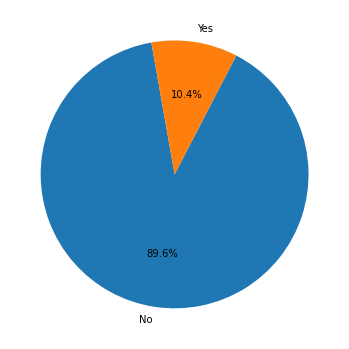

In [713]:
edu_count=X_train.EverBenched.value_counts()
plt.figure(figsize=(6, 8))
plt.pie(edu_count, labels=edu_count.index, autopct='%1.1f%%', startangle=100)

# Step 3: Split Data

In [714]:
X_train_tts, X_test_tts, y_train_tts, y_test_tts = tts(X_train, y_train, test_size=0.3, random_state=123)

# Step 4: Define Column Transformer

In [715]:
numerical_cols = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']
categorical_cols = ['Education', 'City', 'Gender', 'EverBenched', 'Race']


# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)  
    ])


# SMOTE

In [716]:
# Apply preprocessing to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train_tts)

In [717]:
# If y_train_tts is a Series or 1D numpy array:
print("Before SMOTE:", Counter(y_train_tts['LeaveOrNot']))

# Apply SMOTE
smote = SMOTE(random_state=123)
X_train_tts_smote, y_train_tts_smote = smote.fit_resample(X_train_preprocessed, y_train_tts)

# After SMOTE
print("After SMOTE:", Counter(y_train_tts_smote['LeaveOrNot']))

Before SMOTE: Counter({0: 1685, 1: 920})
After SMOTE: Counter({0: 1685, 1: 1685})


# Customize Models and Hyperparameters


In [718]:
# Define your customized RandomForestClassifier
rf = RandomForestClassifier(random_state=123)
lg = LogisticRegression(random_state=123) 
tree_adaboost = AdaBoostClassifier(random_state=123) # tree is default estimator
grd_boost = GradientBoostingClassifier(random_state=123)
xgb = xgb.XGBClassifier(objective='binary:hinge', random_state=123)


# Models with penalizing for imbalanced data
rf_penalize = RandomForestClassifier(random_state=123, class_weight='balanced')
lg_penalize = LogisticRegression(random_state=123, class_weight='balanced')

#Voting:
# voting_calssifiers = [('rf', rf), ('xgb', xgb)]
voting = VotingClassifier(estimators = [('rf', rf), ('xgb', xgb)])

In [719]:
# Hyperparameter grid (adjusted for use with pipeline)
rf_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__min_samples_leaf': [10, 25],
    'classifier__max_depth': [5, 10]
    # 'classifier__criterion': ['gini', 'entropy']
}

In [720]:
# Grid search
lg_param_grid = {'classifier__penalty': ['l1', 'l2'], 
                 'classifier__C': [0.001, 0.01, 1], 
                 'classifier__tol': [0.0001, 0.001], 
                 'classifier__solver': ['liblinear'],
                 'classifier__max_iter': [500]}

In [721]:
ada_param_grid = {'classifier__n_estimators': [10, 50, 100], 
                 'classifier__learning_rate': [0.01, 1, 5]}

In [722]:
grdboost_param_grid = {'classifier__n_estimators': [50, 100], 
                       'classifier__learning_rate': [0.1, 1],
                       'classifier__max_depth': [3, 10]}

In [723]:
xgboost_param_grid = {'classifier__learning_rate' : [0.01, 0.1, 1],
                      'classifier__max_depth' : [3,6, 9],
                      'classifier__min_child_weight' : [0, 1, 2,6]}
                  
        
voting_param_grid = {'classifier__voting': ['soft', 'hard']
}

# Create a Pipeline

In [724]:
pipeline = Pipeline([
        ('classifier', xgb)
])

# Train the Model

In [725]:
y_train.dtypes

LeaveOrNot    int64
dtype: object

In [726]:
# GridSearchCV with the pipeline
model_gs = GridSearchCV(estimator=pipeline, param_grid=xgboost_param_grid, cv=10, scoring='f1')

# Fit GridSearchCV 
model_gs.fit(X_train_tts_smote, y_train_tts_smote.values.ravel())
# pipeline.fit(X_train_tts, y_train_tts.values.ravel())

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_const...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='binary:hinge', ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1],
                         'classifier__max_depth': [3, 6, 9],
                         'classifier__min_child_weight': [0, 1, 2, 6]},
             scoring='f1')

In [727]:
# model_gs.named_steps['classifier']
# dir(model_gs)
# model_gs.steps[1][1].feature_importance_

In [728]:
# Output the best parameters
print("Best Parameters:", model_gs.best_params_)

# Define the best estimator
best_model = model_gs.best_estimator_

best_model.classes_

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_child_weight': 6}


array([0, 1])

In [729]:
# f = best_model.named_steps['classifier']
# f.feature_importance_

#  Evaluate the Model

In [730]:
X_test_tts = preprocessor.transform(X_test_tts)

In [731]:
predictions = best_model.predict(X_test_tts)
print(classification_report(y_test_tts, predictions))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       730
           1       0.81      0.67      0.73       387

    accuracy                           0.83      1117
   macro avg       0.83      0.79      0.81      1117
weighted avg       0.83      0.83      0.83      1117



In [732]:
the_f1 = f1_score(y_test_tts, predictions)
print(f"The f1 on the test set is : {the_f1}")

The f1 on the test set is : 0.7337110481586403


Text(33.0, 0.5, 'Actual')

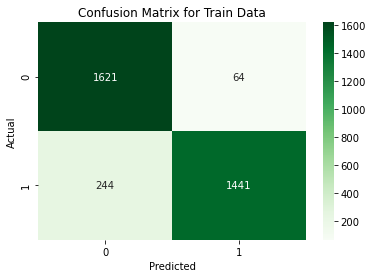

In [733]:
# Confusion Matrix for Training Data
conf_matrix_train = confusion_matrix(y_train_tts_smote, best_model.predict(X_train_tts_smote))
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='Greens')
plt.title('Confusion Matrix for Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

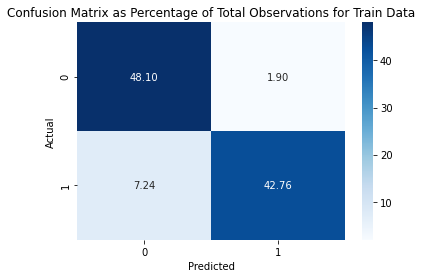

In [734]:
# Calculate the percentage for each cell
total = np.sum(conf_matrix_train)
conf_matrix_percentage_train = (conf_matrix_train / total) * 100

# Plotting the confusion matrix as a heatmap
sns.heatmap(conf_matrix_percentage_train, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix as Percentage of Total Observations for Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

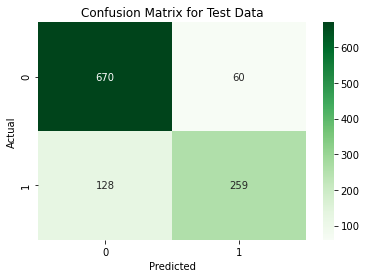

In [735]:
# Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(y_test_tts, predictions)
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Greens')
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

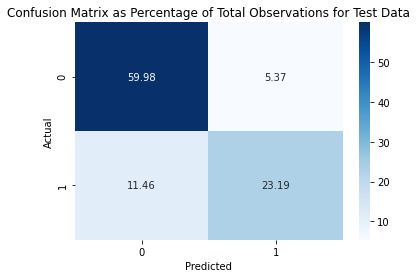

In [736]:
# Calculate the percentage for each cell
total = np.sum(conf_matrix_test)
conf_matrix_percentage_test = (conf_matrix_test / total) * 100

# Plotting the confusion matrix as a heatmap
sns.heatmap(conf_matrix_percentage_test, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix as Percentage of Total Observations for Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

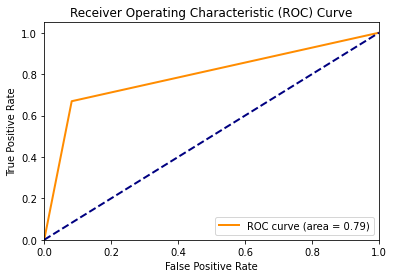

In [737]:
# ROC Curve for Test Data
y_test_proba = best_model.predict_proba(X_test_tts)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_tts, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Submission

In [738]:
X_test.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
911,Bachelors,2014,Bangalore,3,25.0,Female,No,2,white
2235,Bachelors,2016,Bangalore,3,28.0,Female,No,5,white


In [739]:
X_test.shape
X_test.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
Race                         0
dtype: int64

In [740]:
# external test dataset should undergo the same preprocessing steps as training dataset
X_test_proc = preprocessor.transform(X_test)
# Get the feature names for categorical columns after one-hot encoding
# 'onehot' is the name of the OneHotEncoder step in your categorical pipeline
one_hot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

# Combine with the numerical column names
all_feature_names = numerical_cols + list(one_hot_feature_names)

# Convert to DataFrame
X_test_proc_df = pd.DataFrame(X_test_proc, columns=all_feature_names, index=X_test.index)

# Display the first two rows of the processed DataFrame
X_test_proc_df.head(2)

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Female,Gender_Male,EverBenched_No,EverBenched_Yes,Race_black,Race_red,Race_white,Race_yellow
id,,,,,,,,,,,,,,,,,,
911,-0.575926,0.5445,-1.223099,-0.589966,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2235,0.494561,0.5445,-0.605779,1.330311,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Picked the best model to generate predictions:

In [741]:
final_y_pred = best_model.predict(X_test_proc)  # best_model inner pipeline ensurses the preprocessing of X_test
final_y_pred.shape

(931,)

Create a dictionary with the predicted values {id: prediction}

In [742]:
prediction_dict = {id_: pred for id_, pred in zip(X_test.index, final_y_pred)}

# Convert NumPy int64 types to native Python int types in the dictionary (JASON requirement)
prediction_dict_converted = {int(id_): int(pred) for id_, pred in prediction_dict.items()}

 Convert dictionary to JSON File

In [743]:
with open('Daria_non_final_predictions.json', 'w') as f:
    json.dump(prediction_dict_converted, f)